In [ ]:
!pip install walloc PyWavelets pytorch-wavelets

In [ ]:
!wget "https://r0k.us/graphics/kodak/kodak/kodim05.png"

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import display
from torchvision.transforms import ToPILImage, PILToTensor
from walloc.walloc import Walloc
class Args: pass

In [2]:
device = "cpu"
checkpoint = torch.load("v0.6.1.pth",map_location="cpu")
args = checkpoint['args']
codec = Walloc(
    channels = args.channels,
    J = args.J,
    N = args.N,
    latent_dim = args.latent_dim,
    latent_bits = 5
)
codec.load_state_dict(checkpoint['model_state_dict'])
codec = codec.to(device)

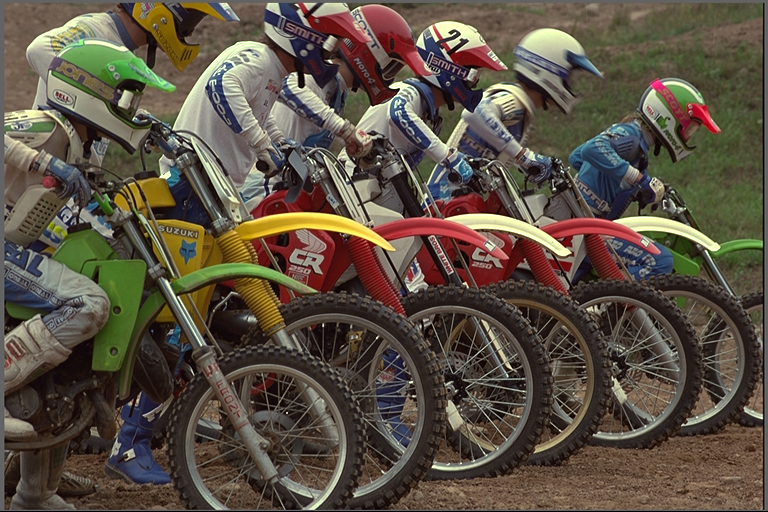

In [3]:
img = Image.open("kodim05.png")
img

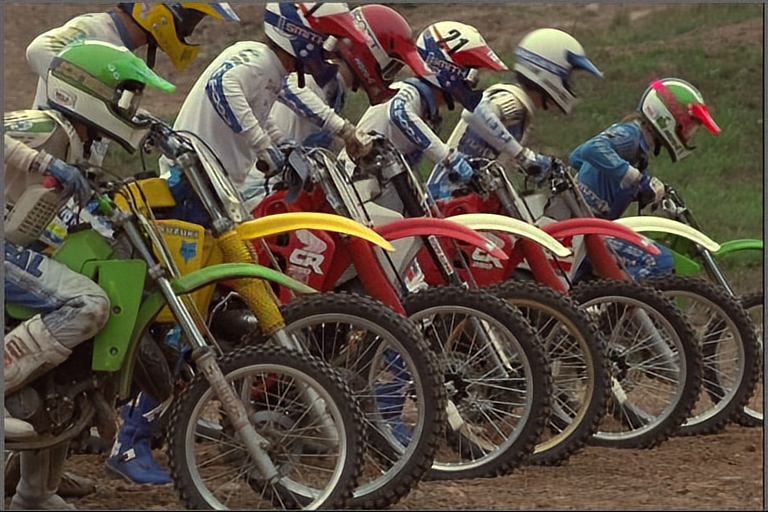

In [4]:
with torch.no_grad():
    codec.eval()
    x = PILToTensor()(img).to(torch.float)
    x = (x/255 - 0.5).unsqueeze(0).to(device)
    x_hat, _, _ = codec(x)
ToPILImage()(x_hat[0]+0.5)

In [5]:
with torch.no_grad():
    codec.eval()
    X = codec.wavelet_analysis(x,J=codec.J)
    Y = codec.encoder(X)
    X_hat = codec.decoder(Y)
    x_hat = codec.wavelet_synthesis(X_hat,J=codec.J)

print(f"dimensionality reduction: {x.numel()/Y.numel()}x")

dimensionality reduction: 12.0x


In [6]:
Y.unique()

tensor([-15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,
         -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,
          9.,  10.,  11.,  12.,  13.,  14.,  15.])

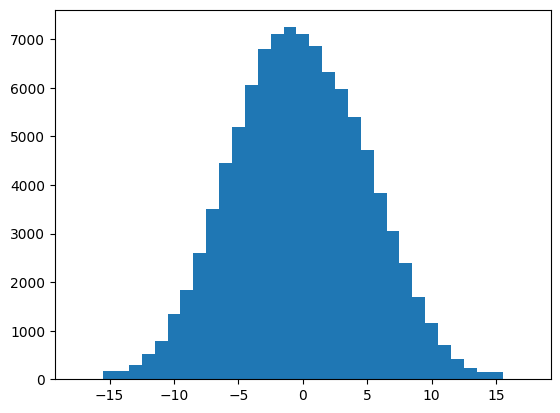

In [7]:
plt.hist(Y.flatten().numpy(),range=(-17.5,17.5),bins=35);

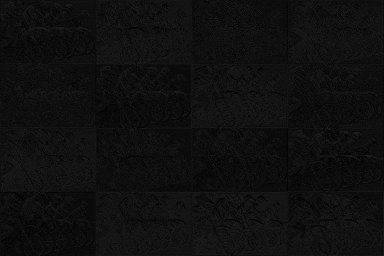

In [8]:
grid_size = 4
n_channels, H, W = Y[0].shape
combined_image = Image.new('L', (W * grid_size, H * grid_size))
size_bytes = 0
for i, channel in enumerate(Y[0]):
    channel = (channel+16).to(torch.uint8)
    row = i // grid_size
    col = i % grid_size
    channel = ToPILImage()(channel)
    combined_image.paste(channel, (col * W, row * H))
combined_image

In [9]:
combined_image.save('tmp.png')
print("compression_ratio: ", x.numel()/os.path.getsize("tmp.png"))

compression_ratio:  20.792244646161983


In [10]:
!jupyter nbconvert --to markdown README.ipynb

[NbConvertApp] Converting notebook README.ipynb to markdown
[NbConvertApp] Support files will be in README_files/
[NbConvertApp] Writing 2336 bytes to README.md
